In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import qutip
from qutip import *
from tqdm import tqdm
from qutip.solver import correlation_2op_1t
from matplotlib import rc
from scipy.linalg import expm
from scipy.fft import ifftshift
import scipy.signal as signal
from scipy.special import factorial
import matplotlib as mpl
from matplotlib import cm
from brokenaxes import brokenaxes  # Librería para ejes rotos
import pandas as pd
from joblib import Parallel, delayed
import ast
from optomechanics import *

In [37]:
#SYSTEM'S PARAMETERS
hbar=1
kappa= 250e-3 
g0 = 0.01 
Omega= 0.005  
wm=100e-3
wc = 2.5 
gamma_m= 1e-3
n_th = np.linspace(0.007, 0.025, 4) 
wl = wc
wlist=np.linspace(2, 3, 10000)
Delta= wc-wl
alpha= Omega/(kappa/2 + 1j*Delta) 
alpha2= alpha.conjugate()*alpha
g = g0*abs(alpha)

In [3]:
T= 273.15 #K
freq=wm*(2*np.pi)/(4.135667696e-15) #rad/s
nth=1/(-1+np.exp(1.054571817e-34*freq/(1.380649e-23*T)))
print(nth)

0.014494081251176438


In [4]:
data = []

for i in range(len(n_th)):
    Gamma_plus, Gamma_minus, Gamma_opt = Transition_rates(g0, alpha2, kappa, Delta, wm)
    nb = pop_phonons(gamma_m, Gamma_opt, n_th[i], Gamma_plus)
    S = [emission_spec(w, nb, Gamma_plus, Gamma_minus, Gamma_opt, gamma_m, wl, wm) for w in wlist]
    data.append({
        'g0': g0,
        'nth': n_th[i],
        'Δ': Delta,
        'Omega': Omega,
        'Gamma_plus': np.real(Gamma_plus),
        'Gamma_minus': np.real(Gamma_minus),
        'Gamma_opt': np.real(Gamma_opt),
        'Analytical S': np.real(S),
        'Analytical w': wlist,
        'C': g**2/(kappa*gamma_m), #abs(np.real(Gamma_opt) / gamma_m),
        'g/k': g/kappa
    })

# Convert to DataFrame
df_anal = pd.DataFrame(data)

In [5]:
#Name code: Test_parameter_hamiltonian_anal (in anal we will store the analytical solutions and system's parameters)
df_anal.to_pickle("Test for t range (nth)/Test_t_full_anal.pkl")
df_anal.to_pickle("Test for HS range (nth)/Test_HS_full_anal.pkl")

## Time range convergency test

In [8]:
#NUMERICAL SIMULATION
#Hamiltonian construction
Nc = [12]  # Dimesion of cavity mode
Nm = [10]  # Dimension of vibrational mode
time= np.arange(100,35000,600) 
data=[]
for i in range(len(Nc)):
    for t in time:
        tlist=np.linspace(0, t, 50000)
        dt=tlist[1]-tlist[0]
        a = tensor(destroy(N=Nc[i]), qeye(Nm[i]))
        b = tensor(qeye(Nc[i]), destroy(N=Nm[i]))
        num_b = b.dag() * b
        num_a = a.dag() * a
        #Hlin = hbar*wm*num_b+hbar*Delta*num_a-hbar*abs(alpha)*g0*(a.dag()+a)*(b.dag()+b)
        H = hbar*Delta*num_a+hbar*wm*num_b+1j*Omega*(a.dag()-a)-g0*num_a*(b.dag()+b)
        for j in range(len(n_th)):
            c_ops = [np.sqrt(kappa)*a, np.sqrt((n_th[j]+1)*gamma_m)*b, np.sqrt(n_th[j]*gamma_m)*b.dag()]
            data.append([g0, n_th[j], Nc[i], Nm[i], H, c_ops, a, b, t ,tlist, dt])
        
new_data = pd.DataFrame(data, columns=['g0', 'nth', 'Nc', 'Nm','Hamiltonian', 'c_ops', 'a', 'b', 't', 'tlist', 'dt'])
df=new_data

In [12]:
df

,g0,nth,Nc,Nm,Hamiltonian,c_ops,a,b,t,tlist,dt
0,0.01,0.007,12,10,"Quantum object: dims=[[12, 10], [12, 10]], sha...","[Quantum object: dims=[[12, 10], [12, 10]], sh...","Quantum object: dims=[[12, 10], [12, 10]], sha...","Quantum object: dims=[[12, 10], [12, 10]], sha...",100,"[0.0, 0.002000040000800016, 0.0040000800016000...",0.002000
1,0.01,0.013,12,10,"Quantum object: dims=[[12, 10], [12, 10]], sha...","[Quantum object: dims=[[12, 10], [12, 10]], sh...","Quantum object: dims=[[12, 10], [12, 10]], sha...","Quantum object: dims=[[12, 10], [12, 10]], sha...",100,"[0.0, 0.002000040000800016, 0.0040000800016000...",0.002000
2,0.01,0.019,12,10,"Quantum object: dims=[[12, 10], [12, 10]], sha...","[Quantum object: dims=[[12, 10], [12, 10]], sh...","Quantum object: dims=[[12, 10], [12, 10]], sha...","Quantum object: dims=[[12, 10], [12, 10]], sha...",100,"[0.0, 0.002000040000800016, 0.0040000800016000...",0.002000
3,0.01,0.025,12,10,"Quantum object: dims=[[12, 10], [12, 10]], sha...","[Quantum object: dims=[[12, 10], [12, 10]], sh...","Quantum object: dims=[[12, 10], [12, 10]], sha...","Quantum object: dims=[[12, 10], [12, 10]], sha...",100,"[0.0, 0.002000040000800016, 0.0040000800016000...",0.002000
4,0.01,0.007,12,10,"Quantum object: dims=[[12, 10], [12, 10]], sha...","[Quantum object: dims=[[12, 10], [12, 10]], sh...","Quantum object: dims=[[12, 10], [12, 10]], sha...","Quantum object: dims=[[12, 10], [12, 10]], sha...",700,"[0.0, 0.014000280005600113, 0.0280005600112002...",0.014000
...,...,...,...,...,...,...,...,...,...,...,...
231,0.01,0.025,12,10,"Quantum object: dims=[[12, 10], [12, 10]], sha...","[Quantum object: dims=[[12, 10], [12, 10]], sh...","Quantum object: dims=[[12, 10], [12, 10]], sha...","Quantum object: dims=[[12, 10], [12, 10]], sha...",34300,"[0.0, 0.6860137202744054, 1.3720274405488109, ...",0.686014
232,0.01,0.007,12,10,"Quantum object: dims=[[12, 10], [12, 10]], sha...","[Quantum object: dims=[[12, 10], [12, 10]], sh...","Quantum object: dims=[[12, 10], [12, 10]], sha...","Quantum object: dims=[[12, 10], [12, 10]], sha...",34900,"[0.0, 0.6980139602792056, 1.3960279205584112, ...",0.698014
233,0.01,0.013,12,10,"Quantum object: dims=[[12, 10], [12, 10]], sha...","[Quantum object: dims=[[12, 10], [12, 10]], sh...","Quantum object: dims=[[12, 10], [12, 10]], sha...","Quantum object: dims=[[12, 10], [12, 10]], sha...",34900,"[0.0, 0.6980139602792056, 1.3960279205584112, ...",0.698014
234,0.01,0.019,12,10,"Quantum object: dims=[[12, 10], [12, 10]], sha...","[Quantum object: dims=[[12, 10], [12, 10]], sh...","Quantum object: dims=[[12, 10], [12, 10]], sha...","Quantum object: dims=[[12, 10], [12, 10]], sha...",34900,"[0.0, 0.6980139602792056, 1.3960279205584112, ...",0.698014


In [13]:
%%time

results1 = Parallel(n_jobs=8)(delayed(spectrum_calculation)(df['Hamiltonian'][i], df['tlist'][i], wl, wm, df['c_ops'][i], df['a'][i], df['b'][i]) for i in tqdm(range(len(df))))
for key in results1[0].keys():
    df[key] = [res[key] for res in results1]

100%|██████████| 236/236 [3:06:33<00:00, 47.43s/it]  


CPU times: total: 1min 45s
Wall time: 3h 23min 30s


In [14]:
#Name code: Test_parameter_hamiltonian_num (in num we will store the numerical solutions)
df.to_pickle("Test for t range (nth)/Test_t_full_num.pkl")

In [ ]:
df_anal=pd.read_pickle("Test for t range (g0)/Test_t_full_anal.pkl")
df=pd.read_pickle("Test for t range (g0)/Test_t_full_num.pkl") 

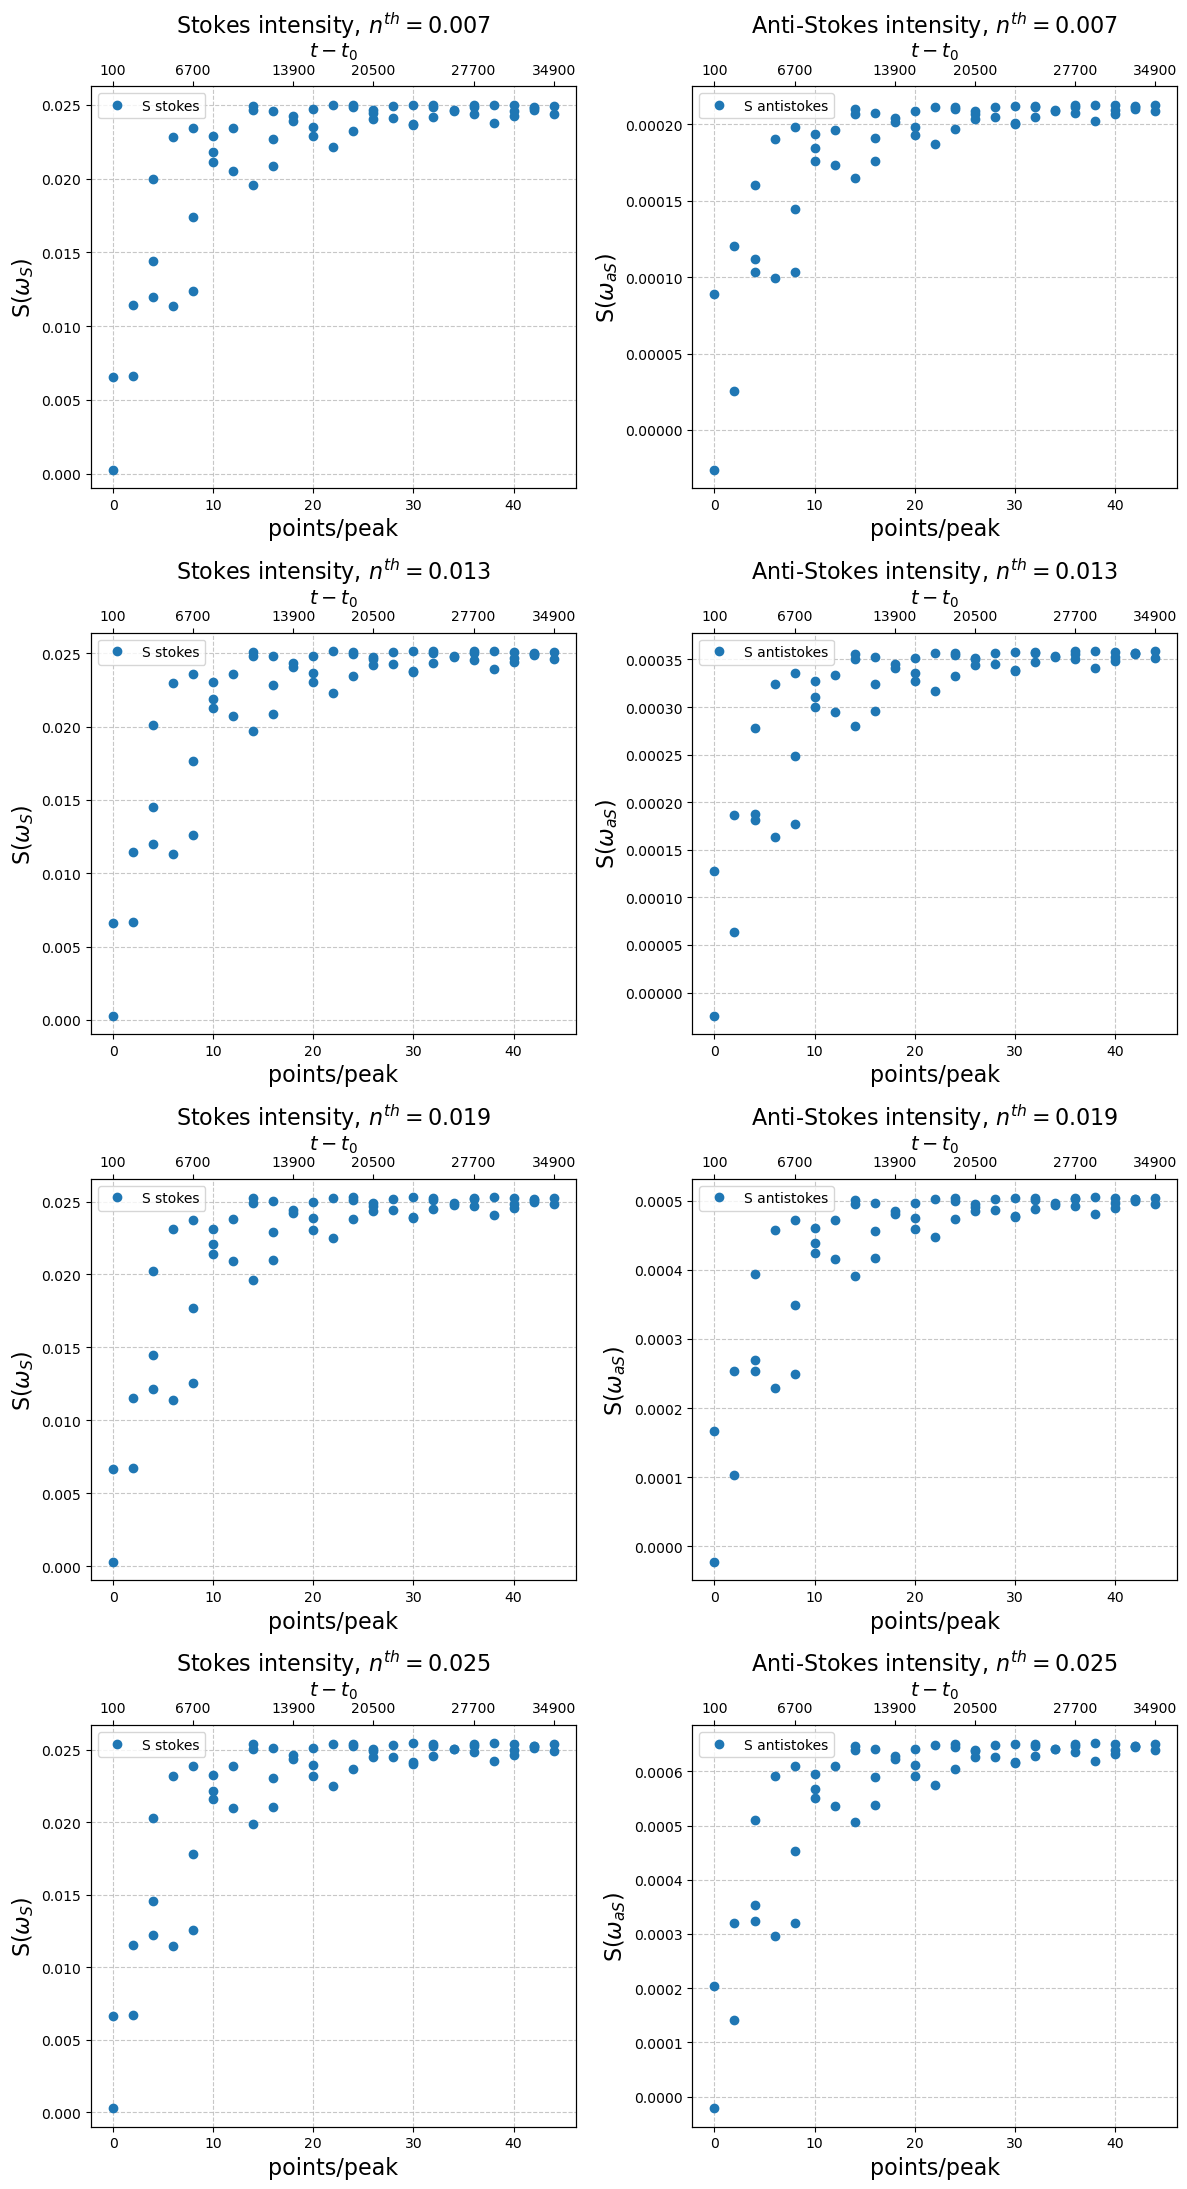

In [31]:
fig, axes = plt.subplots(4, 2, figsize=(12, 22))

for g in range(len(n_th)):
    # Filtr
    data = df[df['nth'] == n_th[g]]

    # Data to plot
    x1 = data['S1 points/peak'].values
    y1 = data['S1'].values
    x2 = data['AS1 points/peak'].values
    y2 = data['AS1'].values
    t_vals = data['t'].values

    # Plots
    axes[g,0].plot(x1, y1, 'o', label='S stokes')
    axes[g,1].plot(x2, y2, 'o', label='S antistokes')

    for i in range(2):
        axes[g,i].legend(loc=0)
        axes[g,i].set_xlabel(r"points/peak", fontsize=16)
        axes[g,i].grid(True, linestyle='--', alpha=0.7)
        top_ax = axes[g,i].twiny()
        top_ax.set_xlim(axes[g,i].get_xlim())
        idx = np.linspace(0, len(x1)-1, 6, dtype=int)
        top_ax.set_xticks(x1[idx])
        top_ax.set_xticklabels([f"{t_vals[j]}" for j in idx])  # o f"{t_vals[i]:.0f}" si querés sin decimales
        top_ax.set_xlabel("$t-t_0$", fontsize=14)

    axes[g,0].set_ylabel(r"S($\omega_S$)", fontsize=16)
    axes[g,1].set_ylabel(r"S($\omega_{aS}$)", fontsize=16)
    
    axes[g,0].set_title(r"Stokes intensity, $n^{th}=$"+f'{n_th[g]:.3f}', fontsize=16)
    axes[g,1].set_title(r"Anti-Stokes intensity, $n^{th}=$"+f'{n_th[g]:.3f}', fontsize=16)

plt.tight_layout()
plt.savefig("Test for t range (nth)/Convergency_of_signals.pdf", format='pdf', bbox_inches='tight')
plt.show()

__________________________________

## Hilbert space convergency test

In [15]:
#NUMERICAL SIMULATION
#Hamiltonian construction
Nc = [4, 6, 8, 10, 12, 14, 16]  
Nm = [2, 4, 6, 8, 10, 12, 14]  
time= [30000] 
data=[]
for i in range(len(Nc)):
    for t in time:
        tlist=np.linspace(0, t, 50000)
        dt=tlist[1]-tlist[0]
        a = tensor(destroy(N=Nc[i]), qeye(Nm[i]))
        b = tensor(qeye(Nc[i]), destroy(N=Nm[i]))
        num_b = b.dag() * b
        num_a = a.dag() * a
        #Choose Hamiltonian
        Hlin = hbar*wm*num_b+hbar*Delta*num_a-hbar*abs(alpha)*g0*(a.dag()+a)*(b.dag()+b)
        H = hbar*Delta*num_a+hbar*wm*num_b+1j*Omega*(a.dag()-a)-g0*num_a*(b.dag()+b)
        for j in range(len(n_th)):
            c_ops = [np.sqrt(kappa)*a, np.sqrt((n_th[j]+1)*gamma_m)*b, np.sqrt(n_th[j]*gamma_m)*b.dag()]
            data.append([g0, n_th[j], Nc[i], Nm[i], H, c_ops, a, b, t ,tlist, dt])
        
new_data = pd.DataFrame(data, columns=['g0', 'nth', 'Nc', 'Nm','Hamiltonian', 'c_ops', 'a', 'b', 't', 'tlist', 'dt'])
df=new_data

In [16]:
df

,g0,nth,Nc,Nm,Hamiltonian,c_ops,a,b,t,tlist,dt
0,0.01,0.007,4,2,"Quantum object: dims=[[4, 2], [4, 2]], shape=(...","[Quantum object: dims=[[4, 2], [4, 2]], shape=...","Quantum object: dims=[[4, 2], [4, 2]], shape=(...","Quantum object: dims=[[4, 2], [4, 2]], shape=(...",30000,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",0.600012
1,0.01,0.009,4,2,"Quantum object: dims=[[4, 2], [4, 2]], shape=(...","[Quantum object: dims=[[4, 2], [4, 2]], shape=...","Quantum object: dims=[[4, 2], [4, 2]], shape=(...","Quantum object: dims=[[4, 2], [4, 2]], shape=(...",30000,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",0.600012
2,0.01,0.011,4,2,"Quantum object: dims=[[4, 2], [4, 2]], shape=(...","[Quantum object: dims=[[4, 2], [4, 2]], shape=...","Quantum object: dims=[[4, 2], [4, 2]], shape=(...","Quantum object: dims=[[4, 2], [4, 2]], shape=(...",30000,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",0.600012
3,0.01,0.013,4,2,"Quantum object: dims=[[4, 2], [4, 2]], shape=(...","[Quantum object: dims=[[4, 2], [4, 2]], shape=...","Quantum object: dims=[[4, 2], [4, 2]], shape=(...","Quantum object: dims=[[4, 2], [4, 2]], shape=(...",30000,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",0.600012
4,0.01,0.015,4,2,"Quantum object: dims=[[4, 2], [4, 2]], shape=(...","[Quantum object: dims=[[4, 2], [4, 2]], shape=...","Quantum object: dims=[[4, 2], [4, 2]], shape=(...","Quantum object: dims=[[4, 2], [4, 2]], shape=(...",30000,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",0.600012
...,...,...,...,...,...,...,...,...,...,...,...
65,0.01,0.017,16,14,"Quantum object: dims=[[16, 14], [16, 14]], sha...","[Quantum object: dims=[[16, 14], [16, 14]], sh...","Quantum object: dims=[[16, 14], [16, 14]], sha...","Quantum object: dims=[[16, 14], [16, 14]], sha...",30000,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",0.600012
66,0.01,0.019,16,14,"Quantum object: dims=[[16, 14], [16, 14]], sha...","[Quantum object: dims=[[16, 14], [16, 14]], sh...","Quantum object: dims=[[16, 14], [16, 14]], sha...","Quantum object: dims=[[16, 14], [16, 14]], sha...",30000,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",0.600012
67,0.01,0.021,16,14,"Quantum object: dims=[[16, 14], [16, 14]], sha...","[Quantum object: dims=[[16, 14], [16, 14]], sh...","Quantum object: dims=[[16, 14], [16, 14]], sha...","Quantum object: dims=[[16, 14], [16, 14]], sha...",30000,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",0.600012
68,0.01,0.023,16,14,"Quantum object: dims=[[16, 14], [16, 14]], sha...","[Quantum object: dims=[[16, 14], [16, 14]], sh...","Quantum object: dims=[[16, 14], [16, 14]], sha...","Quantum object: dims=[[16, 14], [16, 14]], sha...",30000,"[0.0, 0.6000120002400048, 1.2000240004800096, ...",0.600012


In [17]:
%%time

results1 = Parallel(n_jobs=8)(delayed(spectrum_calculation)(df['Hamiltonian'][i], df['tlist'][i], wl, wm, df['c_ops'][i], df['a'][i], df['b'][i]) for i in tqdm(range(len(df))))
for key in results1[0].keys():
    df[key] = [res[key] for res in results1]

100%|██████████| 70/70 [50:28<00:00, 43.26s/it]


CPU times: total: 4min 33s
Wall time: 9h 18min 54s


In [18]:
#Name code: Test_parameter_hamiltonian_num (in num we will store the numerical solutions)
df.to_pickle("Test for HS range (nth)/Test_HS_full_num.pkl")

In [34]:
df_anal=pd.read_pickle("Test for HS range (nth)/Test_HS_full_anal.pkl")
df=pd.read_pickle("Test for HS range (nth)/Test_HS_full_num.pkl") 

In [ ]:
df_anal=pd.read_pickle("Test for t range (nth)/Test_t_full_anal.pkl")
df=pd.read_pickle("Test for t range (nth)/Test_t_full_num.pkl") 

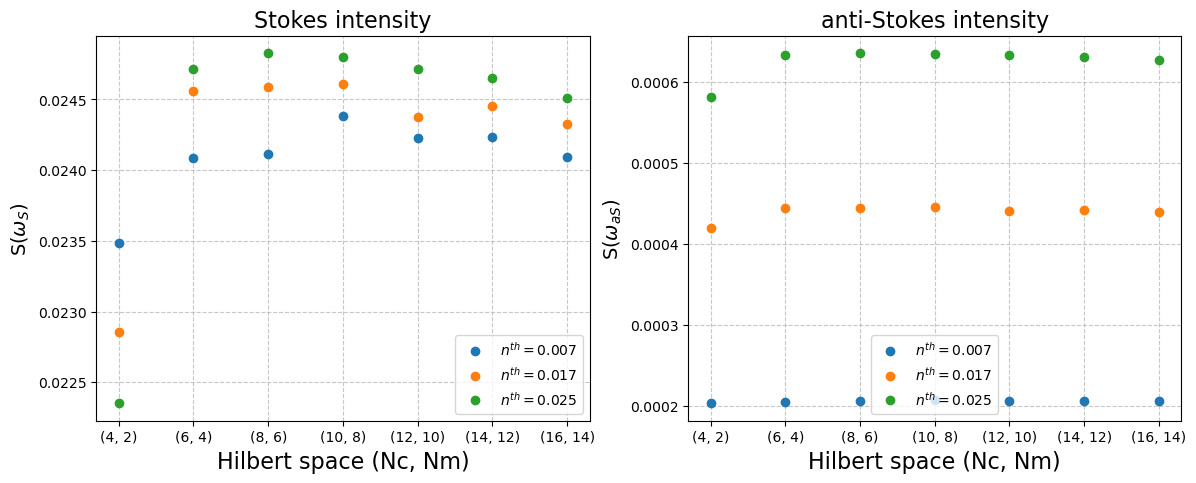

In [36]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
x = list(zip(df[df['nth'] == 0.007]['Nc'], df[df['nth'] == 0.007]['Nm']))

# Convert tuples into strings
x_labels = [str(t) for t in x]
x_pos = range(len(x))

axes[0].plot(x_pos, df[np.isclose(df['nth'], n_th[0])]['S1'], 'o', label=r'$n^{th}=$'+f'{n_th[0]}')
axes[0].plot(x_pos, df[np.isclose(df['nth'], n_th[1])]['S1'], 'o', label=r'$n^{th}=$'+f'{n_th[1]}')
axes[0].plot(x_pos, df[np.isclose(df['nth'], n_th[2])]['S1'], 'o', label=r'$n^{th}=$'+f'{n_th[2]}')
axes[0].plot(x_pos, df[np.isclose(df['nth'], n_th[3])]['S1'], 'o', label=r'$n^{th}=$'+f'{n_th[3]}')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(x_labels)

axes[1].plot(x_pos, df[np.isclose(df['nth'], n_th[0])]['AS1'], 'o', label=r'$n^{th}=$'+f'{n_th[0]}')
axes[1].plot(x_pos, df[np.isclose(df['nth'], n_th[1])]['AS1'], 'o', label=r'$n^{th}=$'+f'{n_th[1]}')
axes[1].plot(x_pos, df[np.isclose(df['nth'], n_th[2])]['AS1'], 'o', label=r'$n^{th}=$'+f'{n_th[2]}')
axes[1].plot(x_pos, df[np.isclose(df['nth'], n_th[3])]['AS1'], 'o', label=r'$n^{th}=$'+f'{n_th[3]}')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(x_labels)

for i in range(2):
    axes[i].legend(loc=0)
    axes[i].set_xlabel('Hilbert space (Nc, Nm)', fontsize=16)
    axes[i].grid(True, linestyle='--', alpha=0.7)
axes[0].set_ylabel(r"S($\omega_S$)", fontsize=14)
axes[1].set_ylabel(r"S($\omega_{aS}$)", fontsize=14)
axes[0].set_title(r"Stokes intensity", fontsize=16)
axes[1].set_title(r"anti-Stokes intensity", fontsize=16)

#plt.savefig("Test for HS range (nth)/Hs vs S1andAS1.pdf", format='pdf', bbox_inches='tight')
plt.show()